In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.impute import MissingIndicator, SimpleImputer, KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def plot_feature_importances(model):
    n_features = X_train_processed.shape[1]
    plt.figure(figsize=(12,50))
    plt.barh(range(n_features), model.feature_importances_, align='edge') 
    plt.yticks(np.arange(n_features), X_train_processed.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')



In [21]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat, average = 'weighted')
    recall = recall_score(y, y_hat, average = 'weighted')
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True)
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [22]:
# train = f.load_processed_train_df()
# test = f.load_test_df()
train = pd.read_csv('../data/processed_data.csv')
train.permit = train.permit.astype(str)

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    59400 non-null  int64  
 1   id                            59400 non-null  int64  
 2   amount_tsh                    59400 non-null  float64
 3   date_recorded                 59400 non-null  object 
 4   gps_height                    59400 non-null  int64  
 5   longitude                     59400 non-null  float64
 6   latitude                      59400 non-null  float64
 7   wpt_name                      59400 non-null  object 
 8   num_private                   59400 non-null  int64  
 9   basin                         59400 non-null  object 
 10  subvillage                    59029 non-null  object 
 11  district_code                 59400 non-null  int64  
 12  ward                          59400 non-null  object 
 13  p

In [138]:
X = train.drop(['id', 'status_group', 'status', 'date_recorded'], axis=1)
y = train.status
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [139]:
ohe_features = ['funder/installer',
               'scheme_management/management', 'permit', 
               'extraction_type/group/class', 'management_group',
               'payment']

In [140]:
cont_features = ['population',
                 'construction_year']

decade_features = []

In [141]:
X_train_ohe = X_train[ohe_features]
X_test_ohe = X_test[ohe_features]
X_train_cont = X_train[cont_features].astype(float)
X_test_cont = X_test[cont_features].astype(float)

In [142]:
X_train_index = X_train.index
X_test_index = X_test.index

In [143]:
ohe = OneHotEncoder(handle_unknown='ignore')
ss = StandardScaler()
X_train_encoded = ohe.fit_transform(X_train_ohe)
X_test_encoded = ohe.transform(X_test_ohe)
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), columns=X_train[cont_features].columns, index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), columns=X_test[cont_features].columns, index=X_test_index)

In [144]:
train_columns = ohe.get_feature_names(input_features=X_train_ohe.columns)
test_columns = ohe.get_feature_names(input_features=X_test_ohe.columns)
X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

In [145]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)


In [146]:
X_train_all = X_train_all.join(X_train[decade_features])
X_test_all = X_test_all.join(X_test[decade_features])

In [147]:
X_train_all.isna().sum()[X_train_all.isna().sum()>0]

Series([], dtype: int64)

In [148]:
X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 2980 to 1888
Columns: 105 entries, population to payment_unknown
dtypes: float64(105)
memory usage: 12.6 MB


In [149]:
rf_no_regional = RandomForestClassifier()

In [150]:
rf_no_regional.fit(X_train_all, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     17146
           1       0.83      0.59      0.69      3243
           2       0.85      0.93      0.89     24161

    accuracy                           0.86     44550
   macro avg       0.86      0.78      0.81     44550
weighted avg       0.87      0.86      0.86     44550

Accurancy:  0.8645791245791246


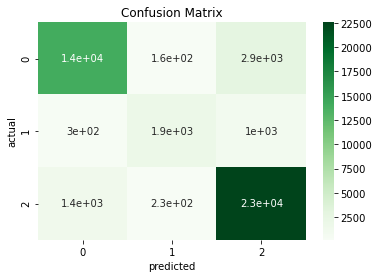

In [151]:
evaluation(y_train, rf_no_regional.predict(X_train_all))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70      5678
           1       0.42      0.27      0.33      1074
           2       0.74      0.82      0.78      8098

    accuracy                           0.72     14850
   macro avg       0.63      0.59      0.60     14850
weighted avg       0.71      0.72      0.71     14850

Accurancy:  0.7210774410774411


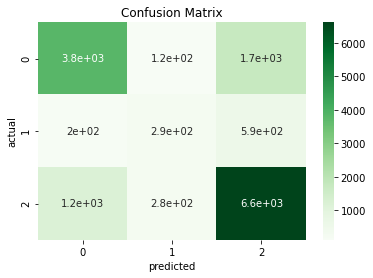

In [152]:
evaluation(y_test, rf_no_regional.predict(X_test_all))

# With Geographic

In [153]:
ohe_features = ['funder/installer', 'region_bins', 'district_code',
                'lga_coded',
               'scheme_management/management', 'permit', 
               'extraction_type/group/class', 'management_group',
               'payment']

In [154]:
cont_features = ['gps_height', 'population',
                 'construction_year']

decade_features = []

In [155]:
X_train_ohe = X_train[ohe_features]
X_test_ohe = X_test[ohe_features]
X_train_cont = X_train[cont_features].astype(float)
X_test_cont = X_test[cont_features].astype(float)

In [156]:
ohe = OneHotEncoder(handle_unknown='ignore')
ss = StandardScaler()
X_train_encoded = ohe.fit_transform(X_train_ohe)
X_test_encoded = ohe.transform(X_test_ohe)
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), columns=X_train[cont_features].columns, index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), columns=X_test[cont_features].columns, index=X_test_index)

In [157]:
train_columns = ohe.get_feature_names(input_features=X_train_ohe.columns)
test_columns = ohe.get_feature_names(input_features=X_test_ohe.columns)
X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

In [158]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)


In [159]:
X_train_all = X_train_all.join(X_train[decade_features])
X_test_all = X_test_all.join(X_test[decade_features])

In [160]:
X_train_all.isna().sum()[X_train_all.isna().sum()>0]

Series([], dtype: int64)

In [161]:
X_test_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 2980 to 1888
Columns: 136 entries, gps_height to payment_unknown
dtypes: float64(136)
memory usage: 16.1 MB


In [162]:
rf_regional = RandomForestClassifier()

In [163]:
rf_regional.fit(X_train_all, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     17146
           1       0.87      0.75      0.81      3243
           2       0.91      0.96      0.93     24161

    accuracy                           0.92     44550
   macro avg       0.91      0.87      0.88     44550
weighted avg       0.92      0.92      0.92     44550

Accurancy:  0.9168574635241302


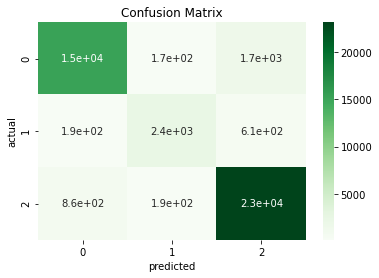

In [164]:
evaluation(y_train, rf_regional.predict(X_train_all))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      5678
           1       0.44      0.30      0.36      1074
           2       0.76      0.82      0.79      8098

    accuracy                           0.74     14850
   macro avg       0.65      0.61      0.62     14850
weighted avg       0.73      0.74      0.73     14850

Accurancy:  0.7385185185185185


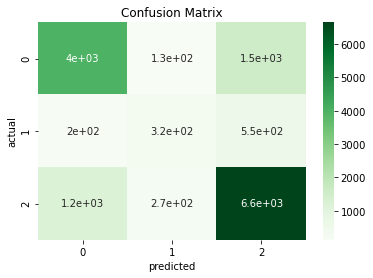

In [165]:
evaluation(y_test, rf_regional.predict(X_test_all))